### Preparing the env dependencies

In [ ]:
import warnings
import kagglehub
import spacy
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter
from wordcloud import WordCloud
from collections import Counter
warnings.simplefilter("ignore")

### Load the latest version of dataset

In [11]:
def getting_datasets(kaggle_paths, online=False):
  datasets = []
  for path, name, columns in kaggle_paths:
    save_path = f"data/{name}"
    try:
        if online:
            df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, path, name)
            df.to_csv(save_path, encoding='utf-8', index=False)
        else:
            df = pd.read_csv(save_path)
        df = df[columns]
        df = df.rename(columns={columns[0]: "resume", columns[1]: "category"})
        df.drop_duplicates()
        print(save_path, df)
        datasets.append(df)
    except:
      print("Error loading dataset", path, name)
      continue
  return datasets

In [12]:
kaggle_paths = [
    ("surendra365/recruitement-dataset", "job_applicant_dataset.csv", ["Resume", "Job Roles"]),
    ("jithinjagadeesh/resume-dataset", "gpt_dataset.csv", ["Resume", "Category"]),
    ("gauravduttakiit/resume-dataset", "UpdatedResumeDataSet.csv", ["Resume", "Category"]),
    ("snehaanbhawal/resume-dataset", "Resume/Resume.csv", ["Resume_str", "Category"]),
    ("noorsaeed/resume-datasets", "clean_resume_data.csv", ["Feature", "Category"]),
]
datasets = getting_datasets(kaggle_paths)

data/job_applicant_dataset.csv                                                  resume              category
0     Proficient in Injury Prevention, Motivation, N...         Fitness Coach
1     Proficient in Healthcare, Pharmacology, Medica...             Physician
2     Proficient in Forecasting, Financial Modelling...     Financial Analyst
3     Proficient in Budgeting, Supply Chain Optimiza...  Supply Chain Manager
4     Proficient in Logistics, Negotiation, Procurem...  Supply Chain Manager
...                                                 ...                   ...
9995  Proficient in Biology, Regulatory Compliance, ...   Biomedical Engineer
9996  Proficient in Communication, Teamwork, Lesson ...               Teacher
9997  Proficient in Medical Terminology, Critical Th...             Physician
9998  Proficient in Exercise Programming, Motivation...         Fitness Coach
9999  Proficient in Content Strategy, Copywriting, C...        Content Writer

[10000 rows x 2 columns]
data/gp

### Preprocessing dataset

In [14]:
def clean_text(text):
  text = str(text).lower()  # Convert to lowercase
  text = re.sub(r'\n', ' ', text)  # Remove newlines
  text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
  text = re.sub(r'https?://\S+|www\.\S+|ftp\.\S+', '', text) # remove ulrs
  text = re.sub(r'\S+@\S+', '', text) # remove emails
  text = re.sub('[^A-Za-z0-9 ]+', '', text) # no special character but space
  text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
  return text.strip()

nlp = spacy.load('en_core_web_sm')
def remove_stopwords(text):
  doc = nlp(text)
  tokens = [token.text for token in doc if not token.is_stop]
  return ' '.join(tokens)

def lemmatizing(text):
  doc = nlp(text)
  lemmatized_tokens = [token.lemma_ for token in doc]
  return ' '.join(lemmatized_tokens)

def cleaning_datasets(datasets, columns):
  for i, df in enumerate(datasets):
    for col in columns:
      df[col] = df[col].apply(clean_text)
      df[col] = df[col].apply(remove_stopwords)
      df[col] = df[col].apply(lemmatizing)
    df = df.drop_duplicates()
    df.to_csv(f"data/filtered/df_{i}.csv", encoding='utf-8', index=False)
  return datasets

In [ ]:
text_columns = ['resume', 'category']
clean_df = cleaning_datasets(datasets, text_columns)

all_data = pd.concat(clean_df, ignore_index=True)
all_data = all_data.drop_duplicates()
all_data.to_csv('data/filtered/data_clean.csv', encoding='utf-8', index=False)
all_data.shape

Catching off-line data

In [2]:
# after that I ask to gemini to generate new data for categories with less count
all_data = pd.read_csv("data/filtered/normalized.csv")
all_data = all_data.dropna()
all_data = all_data.drop_duplicates()
all_data.shape

(18240, 2)

### Data Mining

Word of clouds

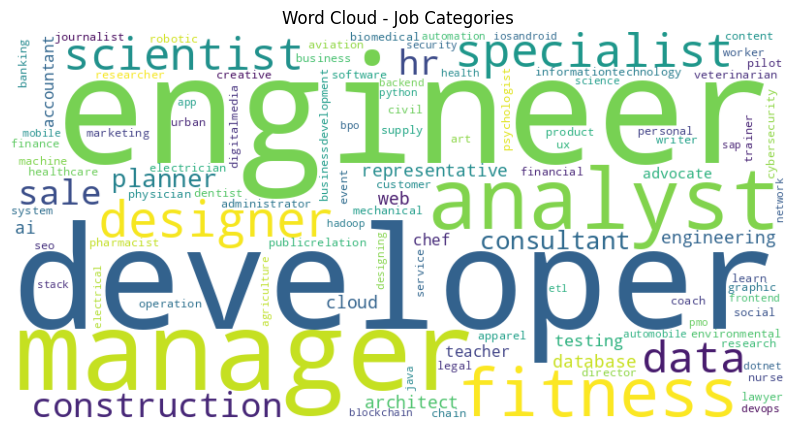

In [4]:
categories = " ".join(all_data['category'].values)
wordcloud_categories = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(categories)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_categories, interpolation='bilinear')
plt.title("Word Cloud - Job Categories")
plt.axis('off')
plt.show()

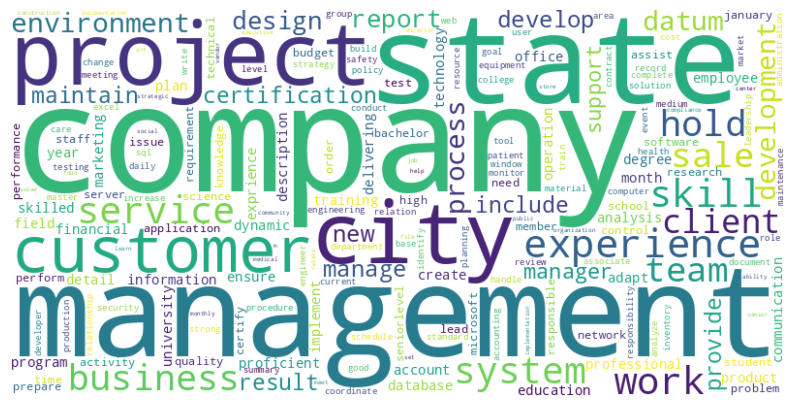

In [16]:
resumes_words = " ".join(all_data['resume'].values)
wordcloud_resumes = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(resumes_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_resumes, interpolation='bilinear')
# plt.title("Word Cloud - Resume")
plt.axis('off')
plt.show()

Resume instances for each job category

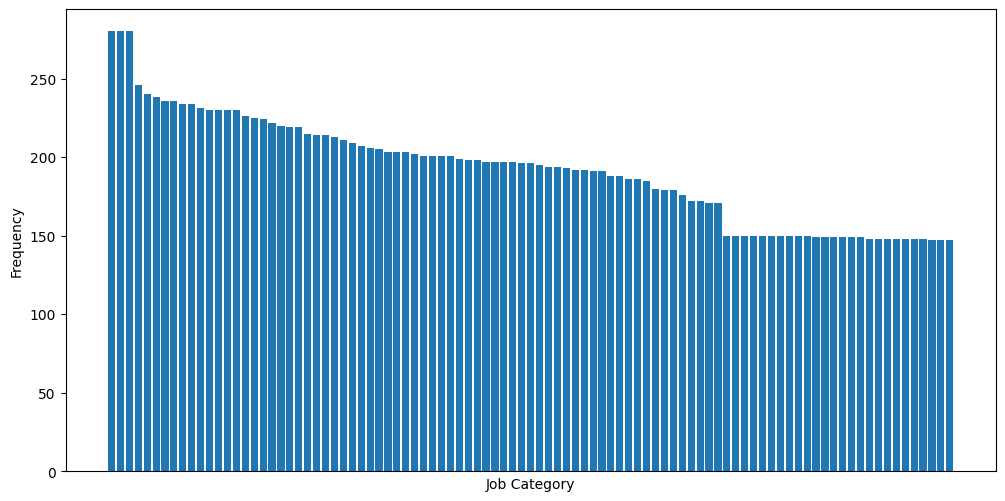

In [15]:
category_counts = Counter(all_data['category'])
common_words = category_counts.most_common(len(category_counts))
words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
# plt.title("Resume instances for each job category")
plt.xlabel("Job Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.xticks([])
plt.show()

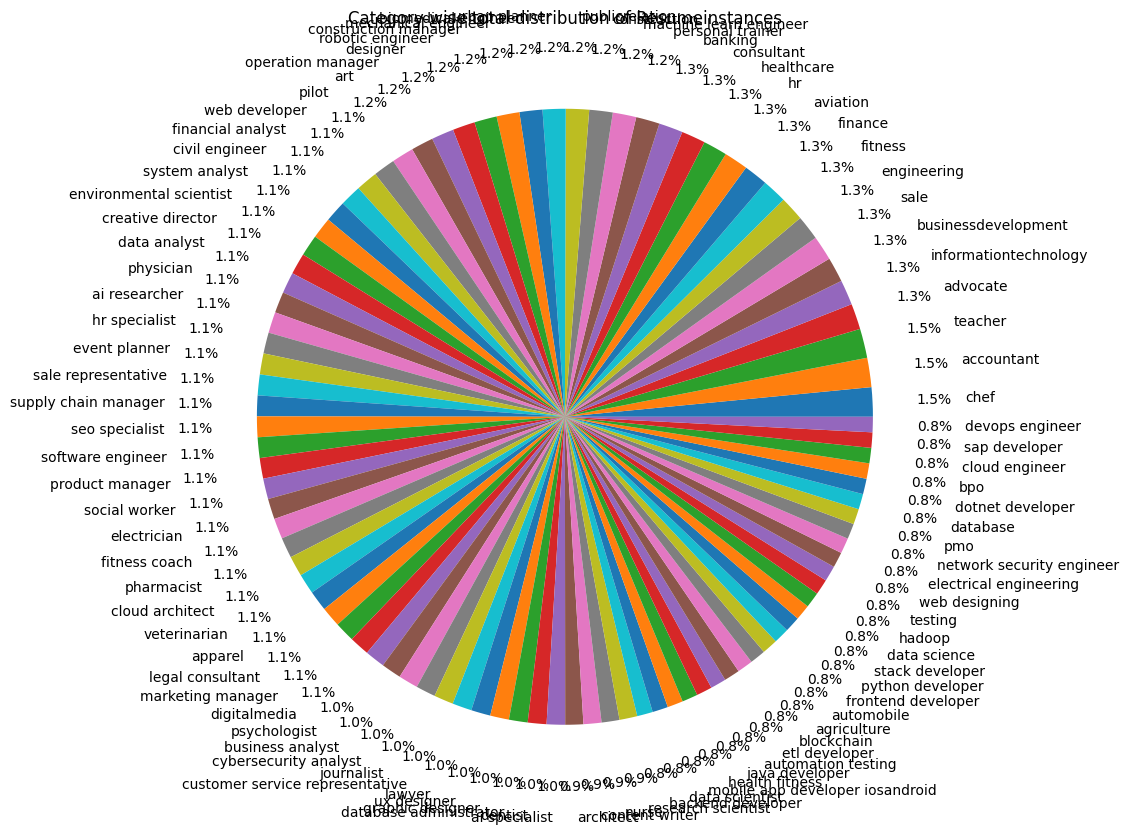

In [44]:
sizes = [c/len(category_counts) for c in counts]

plt.figure(figsize=(20, 10))
plt.pie(sizes, labels=words, autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.3)
plt.title("Category-wise total distribution of Resumeinstances")
plt.show()

In [45]:
category_tb = pd.DataFrame({'job category': words, 'count': counts, 'sizes (%)': sizes})
category_tb

,job category,count,sizes (%)
0,chef,280,2.947368
1,accountant,280,2.947368
2,teacher,280,2.947368
3,advocate,246,2.589474
4,informationtechnology,240,2.526316
...,...,...,...
90,dotnet developer,148,1.557895
91,bpo,148,1.557895
92,cloud engineer,147,1.547368
93,sap developer,147,1.547368


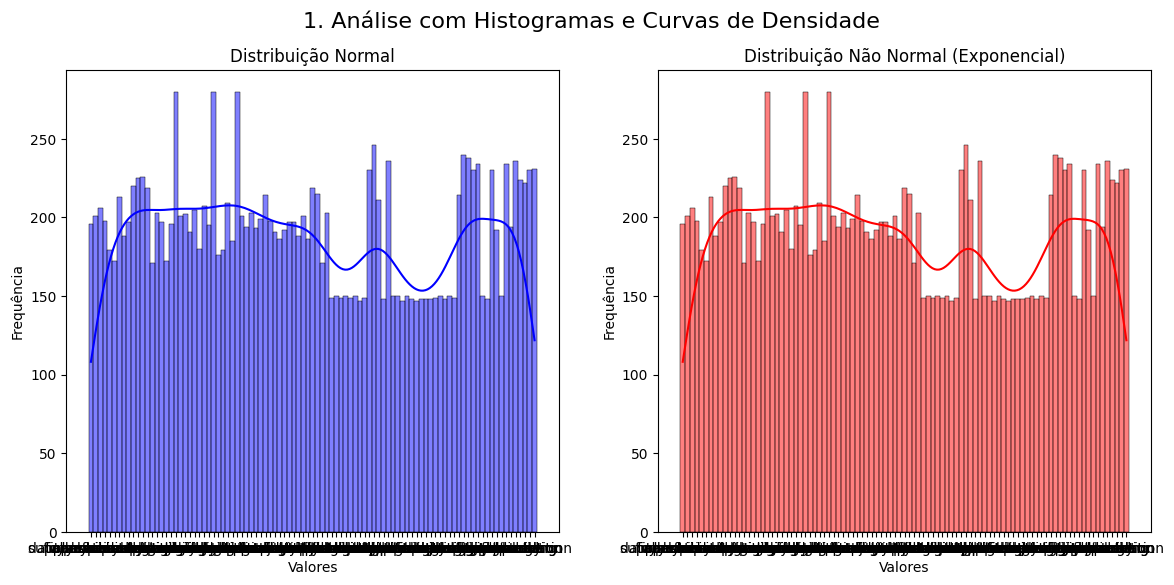

In [7]:
import seaborn as sns
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('1. Análise com Histogramas e Curvas de Densidade', fontsize=16)

# Histograma para os dados normais
sns.histplot(all_data['category'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribuição Normal')
axes[0].set_xlabel('Valores')
axes[0].set_ylabel('Frequência')

# Histograma para os dados não normais
sns.histplot(all_data['category'], kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribuição Não Normal (Exponencial)')
axes[1].set_xlabel('Valores')
axes[1].set_ylabel('Frequência')

plt.show()